# IMDB 영화 리뷰 데이터셋 분류하기
## 1. 데이터 준비하기
- Keras에 기본 포함된 IMDB 데이터셋을 긍정 리뷰와 부정 리뷰로 분류하는 신경망을 만든다.
- 각 데이터는 단어와 매치되는 인덱스들의 리스트로 구성되어 있으며, 긍정과 부정 리뷰의 비율은 각각 50% 이다.

In [1]:
from keras.datasets import imdb

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

- num_words=100 매개변수는 훈련 데이터에서 가장 자주 나타나는 단어 1만개를 사용하겠다는 뜻.

In [26]:
train_data[0][1]

14

In [4]:
train_labels[0]

1

In [5]:
max([max(sequence) for sequence in train_data])

9999

- 재미 삼아 이 데이터를 실제 단어로 구성된 문장으로 바꿔보자.

In [6]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])

- word_index는 단어와 정수 인덱스를 매핑한 딕셔너리
- reverse_word_index는 반대로 정수 인덱스와 단어를 매핑하도록 뒤집는다
- decode 과정에서 0, 1, 2는 각각 '패딩', '문서 시작', '사전에 없음'을 나타내는 인덱스이므로 3을 뺀다

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

 - 신경망에 숫자 리스트를 주입할 수 없기 때문에, 리스트를 one-hot enconding 하여 0과 1로 이루어진 벡터로 변환한다. 예를 들어 시퀀스 [3, 5]는 인덱스 3, 5의 값이 1이고 나머지가 모두 0인 10,000차원의 벡터가 된다.
 - 단어 인덱스가 1만개이기 때문에, 리뷰 데이터를 (25000, 10000) 크기의 텐서로 변환한다.

In [8]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [9]:
len(x_test)

25000

- 마찬가지로 레이블 역시 벡터로 변환한다.

In [10]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 2. 신경망 모델 만들기
- 앞에서 변환한 입력 데이터는 1만 차원의 벡터이며 레이블은 0 또는 1 중 하나의 값을 가지기 때문에 매우 단순하다.
- 이런 문제에 잘 작동하는 네트워크 종류로 relu 활성화 함수(0보다 작은 경우 값을 0으로 대체하고 그 외의 경우는 그대로)를 사용한 연결 층 ```Dense((hidden unit의 수), activation='relu')```를 그냥 쌓은 것이다.
- 이번에 만들 모델은 hidden unit의 개수가 16개인 Dense layer를 2개 연결하고 마지막 결과값으로 1개를 출력하는 Dense layer를 연결하여 구성한다. 마지막 층을 구성하기 위해서는 임의의 값을 0~1 사이로 압축하는 Sigmoid 함수를 활용한다.


In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


- 마지막으로 손실 함수와 옵티마이저를 선택한다.
- 이 문제는 분류 문제이고 최종 출력값이 0에서 1사이인 확률이기 때문에 binary_crossentropy 손실이 적합하다.
- 옵티마이저는 rmsprop을 사용한다.

In [12]:
model.compile(optimizer='rmsprop',
             loss='binary-crossentropy',
             metrics=['accuracy'])

- 케라스에는 rmsprop, binary_crossentropy, accuracy가 포함되어 있어 문자열을 이용하여 사용할 수 있다.
- 옵티마이저의 매개 변수를 바꾸거나 자신만의 손실 함수, 측정 함수를 사용해야 하는 경우 optimzer, loss, metrics 매개변수에 전달하면 된다.

In [13]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

- 위와 같이 Keras 라이브러리에서 optimizers, losses, metrics를 import하여 제공되는 손실/측정 함수 또는 옵티마이저를 사용할 수 있다.

- 훈련 과정 중 과도한 epoch를 반복하게 되면 Train set data에 overfitting이 일어나고 Train set에 속하지 않은 다른 데이터에 대한 정확도가 떨어질 수 있기 때문에, train set의 일부분을 분리해서 validation set을 만든다.
- Validation set의 데이터는 마지막 단계에서의 Test set과 마찬가지로 모델을 학습시키지 않지만, 훈련 과정에서 overfitting이 일어나는 epoch의 횟수를 알아내는데 사용된다. Validation loss가 Train loss보다 커지기 시작하는 시점 즉 Validation set의 정확도가 Train set의 정확도보다 낮아지는 시점에서부터 overfitting이 일어난다고 볼 수 있다.

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]


## 3. 신경망 학습 진행 및 결과 분석
- 학습 데이터 준비가 끝나면 model.fit() 함수를 활용하여 학습을 진행한다. 첫 학습에서는 epoch를 20회 정도로 하였으며, 512개의 미니 배치 단위로 학습이 진행된다.
- Validation set을 활용하기 위해 validation_data 파라미터에 앞에서 분리해두었던 Validation set 데이터를 입력했다.

In [15]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 41ms/step - loss: 0.5507 - binary_accuracy: 0.7581 - val_loss: 0.4240 - val_binary_accuracy: 0.8543
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3379 - binary_accuracy: 0.8967 - val_loss: 0.3490 - val_binary_accuracy: 0.8687
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2411 - binary_accuracy: 0.9295 - val_loss: 0.2938 - val_binary_accuracy: 0.8872
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1874 - binary_accuracy: 0.9425 - val_loss: 0.3460 - val_binary_accuracy: 0.8597
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1528 - binary_accuracy: 0.9554 - val_loss: 0.2841 - val_binary_accuracy: 0.8864
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1259 - binary_accuracy: 0.9628 - val_loss: 0.2921 - val_binary_accuracy: 0.8837
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - los

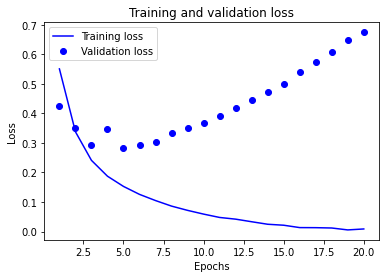

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

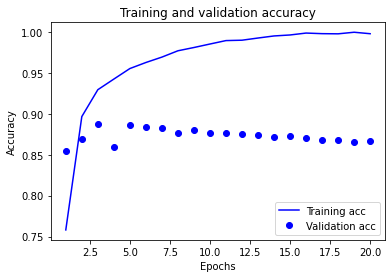

In [17]:
plt.clf()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 학습 결과를 보면 약 4번째 epoch부터 Training set과 Validation set의 accuracy와 loss가 역전되기 시작한다. 즉, 4번 이상 학습을 진항하게 되면 Train set에 대한 overfitting이 발생하게 되는 것이다.
- 처음과 같은 형태로 model을 다시 준비하고, epoch를 4회만 반복하도록 하여 처음부터 다시 학습을 진행하도록 한다.

In [18]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 1s 12ms/step - loss: 0.4704 - binary_accuracy: 0.8219
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2688 - binary_accuracy: 0.9070
Epoch 3/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2051 - binary_accuracy: 0.9266
Epoch 4/4
49/49 [==============================] - 1s 12ms/step - loss: 0.1713 - binary_accuracy: 0.9380


- 최종 학습이 끝난 모델의 성능을 미리 지정해두었던 Test set 데이터를 활용하여 평가해 본다.
- Jupyter Notebook 실행 중 메모리 부족으로 인해 오류가 발생할 수 있어서 책과 다르게 batch_size=512로 지정했다.(상관 없는 듯 하다)

In [19]:
results = model.evaluate(x_test, y_test, batch_size=512)

49/49 [==============================] - 1s 10ms/step - loss: 0.2874 - binary_accuracy: 0.8860


In [24]:
print(model.metrics_names)
print(results)

['loss', 'binary_accuracy']
[0.2874431312084198, 0.8859999775886536]


- 매우 간단한 방법으로도 Test set에 대해 약 88%의 정확도를 가지는 모델을 얻어낼 수 있었다. 고급 기법을 활용하면 더 높은 성능(95% 가까이)을 얻을 수도 있을 것이다.
- 훈련시킨 모델을 실전 환경에서 사용하고 싶을 때, predict 메서드를 활용하여 어떤 새로운 리뷰가 긍정일지 또는 부정일지 예측할 수 있다. 예측 결과를 보면 어떤 데이터에 대해서는 매우 강한 확신을 가지고 예측할 수 있지만(확률 0.9 이상 또는 0.1 이하) 어떤 데이터에 대해서는 불확실한 예측(확률 0.4~0.6)을 보여준다.

In [25]:
model.predict(x_test)

array([[0.21878666],
       [0.99958724],
       [0.8811385 ],
       ...,
       [0.11463819],
       [0.06556803],
       [0.5612953 ]], dtype=float32)

## 4. 정리
- 원본 데이터는 대부분 바로 신경망에 주입하기 매우 어렵고 적절한 전처리 과정이 필요하다. 여기서 사용된 단어 시퀀스는 이진 벡터 또는 다른 인코딩 방식으로 처리될 수 있다.
- 가장 대표적인 모델 구성 방법으로 relu 활성화 함수와 함께 Dense 층을 쌓은 네트워크를 구성하였다. 이 모델은 마지막에 확률을 나타내는 0과 1사이의 스칼라 값을 출력하기 위해 sigmoid를 활성화 함수로 사용하는 층으로 끝나게 된다.
- 이 모델과 같은 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 binary_crossentropy 손실 함수를 사용한다.
- 옵티마이저는 일반적으로 사용되는 rmsprop을 사용했다.
- 훈련에 사용되는 데이터인 train set은 학습 과정에서 모델을 변화시키는데, 너무 과도하게 학습이 진행되면 해당 데이터에 대한 overfitting이 일어날 수 있어 일부분의 데이터를 validation set으로 구성하여 사용한다. 이는 모델을 변화시키지는 않지만 overfitting이 일어날 수 있는 임계점을 찾을 수 있도록 해준다.